# Forecasting Intermittent Demand (TimeGPT + Statistical Baselines)

*Auto-generated on 2025-10-27 13:56*

本Notebook参考并复现 Nixtla 官方用例：**Forecasting Intermittent Demand** (间歇性需求预测)，包含：数据加载、对数变换、TimeGPT 预测与评估、与经典间歇性需求模型的对比，以及加入节假日等外生变量的示例。

> 原文档：Nixtla Use Case — Forecasting Intermittent Demand（请在浏览器中打开官方页面获取更多背景与说明）


## 1. 环境准备 / 安装依赖

In [1]:
## 如需在本地/服务器首次运行，请取消下一行注释以安装依赖
# !pip install --upgrade nixtla statsforecast utilsforecast pandas numpy matplotlib

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nixtla import NixtlaClient
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB


/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


## 2. 设置 TimeGPT API Key

In [2]:
client = NixtlaClient(api_key='nixak-OHoueeW0ZFRJUMwQcSh2kUDb15LuFW43nQm50ZOWY4y0b5Kt7Db6ZtHH5X86jlb9mt9yh4TC1V5xrCrZ')


## 3. 加载数据（M5 子集 + 外生变量）

In [3]:
## 示例使用的是开放的 M5 子集，包含 `unique_id`, `ds`, `y` 以及外生变量（价格与事件类型）
url = "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/m5_sales_exog_small.csv"
df = pd.read_csv(url)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id','ds']).reset_index(drop=True)
display(df.head())

print('\n样本量：', len(df), '；系列条数：', df['unique_id'].nunique())

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2011-01-29,3,2.0,0,0,0,0
1,FOODS_1_001,2011-01-30,0,2.0,0,0,0,0
2,FOODS_1_001,2011-01-31,0,2.0,0,0,0,0
3,FOODS_1_001,2011-02-01,1,2.0,0,0,0,0
4,FOODS_1_001,2011-02-02,4,2.0,0,0,0,0



样本量： 15752 ；系列条数： 8


### 可视化

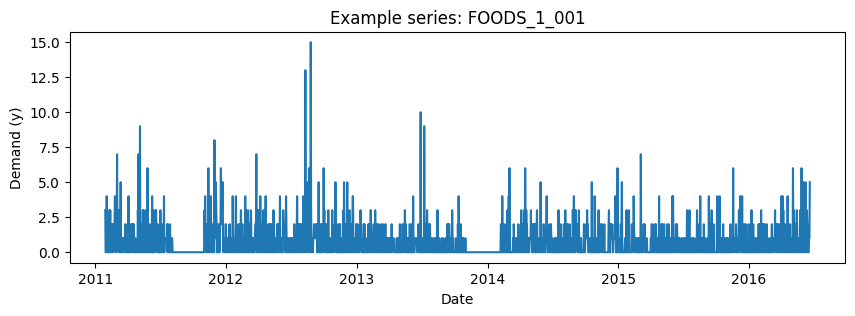

In [4]:
uid = df['unique_id'].iloc[0]
uid = df['unique_id'].unique()[0]
sub = df[df['unique_id']==uid]
plt.figure(figsize=(10,3))
plt.plot(sub['ds'], sub['y'])
plt.title(f'Example series: {uid}')
plt.xlabel('Date'); plt.ylabel('Demand (y)'); plt.show()

## 4. 变换与划分训练/测试集（log1p + 留后法）

In [5]:
# log1p 变换可避免负预测值，并压缩尺度
df_t = df.copy()
df_t['y'] = np.log(df_t['y'] + 1)

# 留出最后 28 天作为测试集（按每个 unique_id 粒度）
H = 28
test_df = df_t.groupby('unique_id', group_keys=False).tail(H)
train_df = df_t.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print('Train size:', len(train_df), ' Test size:', len(test_df))

Train size: 15528  Test size: 224


## 5. 使用 TimeGPT 进行预测

In [6]:
start = time.time()
fcst_df = client.forecast(
    df=train_df,
    h=H,
    level=[80],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)
t_timegpt = time.time() - start
print(f'Time (TimeGPT): {t_timegpt:.2f}s')

# 逆变换回原尺度
val_cols = [c for c in fcst_df.columns if c not in ['ds','unique_id']]
fcst_df[val_cols] = np.exp(fcst_df[val_cols]) - 1
display(fcst_df.head())

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/nixtla/nixtla_client.py:380: UserWarning: `df` contains the following exogenous features: ['sell_price', 'event_type_Cultural', 'event_type_National', 'event_type_Religious', 'event_type_Sporting'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 8.24s


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-lo-80
0,FOODS_1_001,2016-05-23,0.285826,1.836840,-0.417187
1,FOODS_1_001,2016-05-24,0.319420,0.885166,-0.076544
2,FOODS_1_001,2016-05-25,0.286682,0.826315,-0.093501
3,FOODS_1_001,2016-05-26,0.294733,0.814549,-0.076170
4,FOODS_1_001,2016-05-27,0.314707,2.499783,-0.506125


## 6. 评估 TimeGPT 预测（MAE）并作图

Average MAE (TimeGPT):


metric
mae    1.387779
Name: TimeGPT, dtype: float64

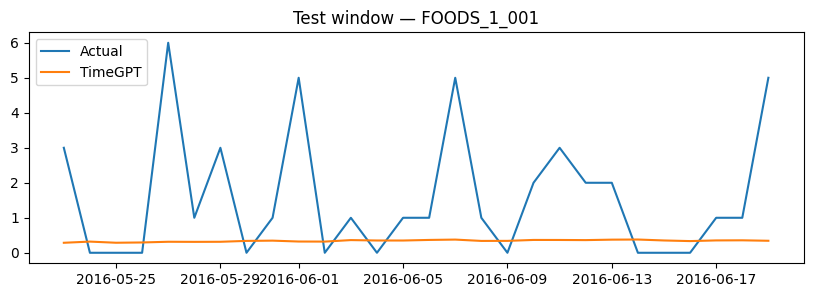

In [7]:
# 合并真实值与预测
test_orig = df.groupby('unique_id', group_keys=False).tail(H).reset_index(drop=True)
eval_df = pd.merge(test_orig, fcst_df, on=['unique_id','ds'], how='left')

# 计算 MAE（按系列 -> 再取均值）
ev = evaluate(
    eval_df,
    metrics=[mae],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)
avg_mae = ev.groupby('metric')['TimeGPT'].mean()
print('Average MAE (TimeGPT):')
display(avg_mae)

# 可视化一个系列的预测区间
ex_id = eval_df['unique_id'].iloc[0]
ex_test = eval_df[eval_df['unique_id']==ex_id]
plt.figure(figsize=(10,3))
plt.plot(ex_test['ds'], ex_test['y'], label='Actual')
plt.plot(ex_test['ds'], ex_test['TimeGPT'], label='TimeGPT')
plt.title(f'Test window — {ex_id}')
plt.legend(); plt.show()

## 7. 与经典间歇性需求模型对比（StatsForecast）

In [8]:
sf = StatsForecast(
    models=[CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(alpha_d=0.1, alpha_p=0.1)],
    freq='D',
    n_jobs=-1
)
start = time.time()
sf.fit(df=train_df[['unique_id','ds','y']])
sf_preds = sf.predict(h=H)
t_stats = time.time() - start
print(f'Time (Statistical models): {t_stats:.2f}s')
display(sf_preds.head())

# 逆变换基线模型回原尺度
sf_preds_cols = [c for c in sf_preds.columns if c not in ['unique_id','ds']]
tmp = df.groupby('unique_id', group_keys=False).tail(H).reset_index(drop=True)[['unique_id','ds','y']].copy()
for c in sf_preds_cols:
    # sf 使用的输入是 log1p 变换后的 y，因此这里需要一致性：
    # 我们训练时已对 y 做了 log1p，因此 sf_preds 也在 log 空间；还原：
    pass

# 注意：上面 sf.fit 我们传入的是 log1p 后的 y（train_df['y']），
# sf.predict 输出同尺度（log 空间）。因此需要合并后做 expm1。
sf_eval = pd.merge(
    df.groupby('unique_id', group_keys=False).tail(H).reset_index(drop=True)[['unique_id','ds','y']],
    sf_preds, on=['unique_id','ds'], how='left'
)
for c in sf_preds_cols:
    sf_eval[c] = np.exp(sf_eval[c]) - 1

# 评估：选择最佳基线，并与 TimeGPT 对比
metrics = evaluate(
    sf_eval,
    metrics=[mae],
    models=sf_preds_cols,
    target_col='y',
    id_col='unique_id'
)
avg_baselines = metrics.groupby('metric')[sf_preds_cols].mean().T.sort_values(by='mae')
print('Statistical baselines average MAE (lower is better):')
display(avg_baselines)


/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_res

Time (Statistical models): 4.14s


,unique_id,ds,CrostonClassic,CrostonOptimized,IMAPA,TSB
0,FOODS_1_001,2016-05-23,0.469437,0.469434,0.368645,0.333796
1,FOODS_1_001,2016-05-24,0.469437,0.469434,0.368645,0.333796
2,FOODS_1_001,2016-05-25,0.469437,0.469434,0.368645,0.333796
3,FOODS_1_001,2016-05-26,0.469437,0.469434,0.368645,0.333796
4,FOODS_1_001,2016-05-27,0.469437,0.469434,0.368645,0.333796


Statistical baselines average MAE (lower is better):


metric,mae
TSB,1.379701
CrostonOptimized,1.394539
IMAPA,1.398704
CrostonClassic,1.488862


## 8. 加入外生变量（节假日/事件）示例

In [9]:
# 选择事件列作为未来已知的外生变量（futr exogenous）
event_cols = ['event_type_Cultural','event_type_National','event_type_Religious','event_type_Sporting']
futr_exog = df[df['ds'].isin(test_orig['ds'])][['unique_id','ds'] + event_cols]

start = time.time()
fcst_ex = client.forecast(
    df=train_df,
    X_df=futr_exog,
    h=H,
    level=[80],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)
t_ex = time.time() - start
print(f'Time (TimeGPT + exog): {t_ex:.2f}s')
fcst_ex[[c for c in fcst_ex.columns if c not in ['unique_id','ds']]] = np.exp(fcst_ex[[c for c in fcst_ex.columns if c not in ['unique_id','ds']]]) - 1

# 评估外生变量版本
eval_ex = pd.merge(test_orig, fcst_ex, on=['unique_id','ds'], how='left')
ev_ex = evaluate(
    eval_ex,
    metrics=[mae],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)
avg_mae_ex = ev_ex.groupby('metric')['TimeGPT'].mean()
print('Average MAE (TimeGPT + exog):')
display(avg_mae_ex)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
/Users/yumengxi/Documents/RA/Assistant_AI_Forecast/Nixtla/nixtla_env/lib/python3.13/site-packages/nixtla/nixtla_client.py:394: UserWarning: `df` contains the following exogenous features: ['sell_price'], but they were not found in `X_df` nor declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['event_type_Cultural', 'event_type_National', 'event_type_Religious', 'event_type_Sporting']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT + exog): 6.05s
Average MAE (TimeGPT + exog):


metric
mae    1.399149
Name: TimeGPT, dtype: float64

## 9. 小结
- TimeGPT 在间歇性需求预测上通常优于经典间歇性模型（例如 Croston 系列、IMAPA、TSB），官方示例约 **~14% MAE** 改善。
- 使用 `log1p` 变换可避免负值预测。
- 加入外生变量（如价格、事件）可以进一步提升效果。

> 注意：实际效果取决于数据质量、外生变量可用性、微调步数与损失函数选择等。